A method to do an opening move book by doing big MCTS:

In [2]:
"""
A MonteCarloTreeSearch Node class:
- Q and N are total reward and visits to node, from basic algorithm
- children are the existing / already created children nodes of that node
- options are all the possible children nodes (MAYBE)
- parent is the parent node - for backpropagation (None for root)
- board - the state the node represents
"""

from math import sqrt, log

class Board:
    def  __init__(self, _board):
        self.board = []
        self.size = len(_board)
        for i in range(len(_board)):
            for j in range(len(_board)):
                self.board.append(_board[i][j])



    def getPiece(self, i,j):
        return self.board[i*self.size + j]

    def setPiece(self, piece, i,j):
        self.board[i*self.size + j] = piece

    def getBoard(self):
        return self.board

    def size(self):
        return self.size

        

class mctsNode:

    def __init__(self, _parent, _board, move):
        self.Q = 0
        self.N = 0
        self.children = []
        self.parent = _parent
        self.leaf = True
        self.size = len(_board)
        self.move = move

        self.options = []
        #generate options (MAYBE)

        # we want board to be a matrix of -1,0,1s
        self.board = _board

    def applyMove(self):
        self.board[self.move[0]][self.move[1]] = 1

    def getMove(self):
        return self.move


    def addChild(self, _child):
        self.children.append(_child)
        self.leaf = False

    def getChildren(self):
        return self.children

    def isLeaf(self):
        return self.leaf
    
    def isRoot(self):
        return self.parent is None

    def UCT(self, c):
        return (self.Q / self.N) + c*sqrt(2*log(self.parent.N)/self.N)

    def Robust(self):
        return self.N

    def BestRobust(self):
        return (self.Q,self.N)

    def getBoard(self):
        return self.board

    def getOptions(self):
        options = []
        for i in range(self.size):
            for j in range(self.size):
                if(self.board[i][j] == 0):
                    options.append((i,j))
        return options

    # def playout(self):
    #     # playout from this node's board to end

    # def backpropagate(self):
    #     # update this node's data and then backpropagate to its parent (unless root)    


# from mctsNode import mctsNode
import random
from copy import deepcopy
import time



# Increase this a bit in any case
# fixedBranchFactor = 3

# timing


def mctsSearch(root, allowance, playouts, _c):
    c = _c
    playoutReps = playouts
    allowedtime = allowance
    start = time.monotonic()

    rootNode = root
    

    # print("enter mctsSearch")   #pprriinntt

    while (time.monotonic() < start + allowedtime):

        # print("iteration: " + str(i))   #pprriinntt
        # print("enter loop with iteration = " + str(i))   #pprriinntt
        
        # Selection
        selectedNode, depth = _treePolicy(rootNode, c, 1)

        # print("done selection, selected node's board: " + str(selectedNode.getBoard()))   #pprriinntt

        # Expansion

        expanded = []

        options = selectedNode.getOptions()

        for i in range(int(len(options)/depth)):
            child, choice = _expandPolicy(selectedNode, options)
            options.remove(choice)
            selectedNode.addChild(child)
            expanded.append(child)

        # print("Done Expansion - expanded: " + str(expanded))    #pprriinntt

        # Playout & Backpropagate for each new child
        
        for child in expanded:
            for reps in range(playoutReps):
                win = _playout(child)  
                # win is 0 or 1
                _backPropagate(child, win)

    return _best(rootNode)



def _treePolicy(root, c, i):
    currentNode = root
    while(not currentNode.isLeaf()):
        currentChildren = currentNode.getChildren()

        # HERE WE DECIDE WHICH CHILD TO PICK ON EACH ITERATION
        # IN THIS CASE WE DO THE GENERALLY AGREED UPON UCT
        # AND THERE ISN'T MUCH TO WONDER ABOUT HERE
        currentNode = max(currentChildren, key=lambda x: x.UCT(c))
        i += 1
    return currentNode, i

def _expandPolicy(selectedNode, options):

    # HERE WE PICK THE NODE(S) TO EXPAND TO FROM THE SELECTED ONE
    # FIRST WILL DO A RANDOMLY PICKED 3-5 RESULTING STATES

    # IDEALLY HERE IS WHERE WE WANT A HEURISTIC FUNCTION / NN
    # SO WE CAN BRANCH OUT TO THE IMPORTANT MOVES TO CONSIDER WITHOUT
    # BRANCHING TO UNNECESSARY ONES

    board = selectedNode.getBoard()

    choice = random.choice(options)


    # board[choice[0]][choice[1]] = 1
    
    nextNode = mctsNode(selectedNode, deepcopy(board), choice)
    nextNode.applyMove()

    return (nextNode,choice)

def _playout(child):

    board = deepcopy(child.getBoard())
    options = child.getOptions()
    colour = -1

    # WE DO A RANDOM PLAYOUT POLICY
    # THIS IS ANOTHER PLACE WHERE WE COULD IMPROVE STUFF
    # BY DOING SOMETHING BETTER THAN RANDOM
    # NOTE IM PLAYING OUT TILL FULL BOARD, BECAUSE IT MAY BE QUICKER TO DO SO,
    # THAN CHECK FOR A WINNER AFTER EVERY MOVE (ROOM FOR ANALYSIS AND IMPROVEMENT)
    while (options):
        choice = random.choice(options)
        options.remove(choice)
        board[choice[0]][choice[1]] = colour
        colour *= -1

    return _winner(board)

def _backPropagate(node, win):
    node.N += 1
    node.Q += win
    if node.parent:
        _backPropagate(node.parent, win)



def _winner(board):
    # CHECK STARTING WITH THE TOP LINE IF THERE IS A CONNECTION TO BOTTOM
    visited = set()
    left = set()

    for j in range(len(board)):
        if(board[0][j] == 1):
            left.add((0,j))

    while left:
        some = left.pop()
        visited.add(some)

        neighbours = _getNeighbours(board,some)
            
        for each in neighbours:
            if(board[each[0]][each[1]] == 1):
                if (each[0] == len(board)-1):
                    return 1
                if each not in visited:
                    left.add(each)
    return 0

def _getNeighbours(board, ij):
    x = ij[1]
    y = ij[0]
    #clockwise neighbours of a x,y
    available = [True,True,True,True,True,True]
    I_DISPLACEMENTS = [-1, -1, 0, 1,  1, 0]
    J_DISPLACEMENTS = [0,  1,  1, 0, -1, -1]
    if(y == 0): 
        available[0] = False
        available[1] = False
    elif(y == len(board)-1):
        available[3] = False
        available[4] = False
    if(x == 0):
        available[4] = False
        available[5] = False
    elif(x == len(board)-1):
        available[1] = False
        available[2] = False
    result = []
    for i in range(6):
        if available[i]:
            result.append((y+I_DISPLACEMENTS[i], x+J_DISPLACEMENTS[i]))
    return result

def _best(root):
    if root.isLeaf():
        return root
    children = root.getChildren()
    # Ill be returning the robust child for now (child with most visits)
    # thats usually a good idea
    return max(children, key=lambda x: x.Robust())

def _values(root):
    children = root.getChildren()
    outputboard = deepcopy(root.getBoard())
    for child in children:
        move = child.getMove()
        outputboard[move[0]][move[1]] = child.BestRobust()
    return outputboard


In [4]:
zeroboard = []
finalboard2 = []
for i in range(11):
    zeroboard.append([])
    finalboard2.append([])
    for j in range(11):
        zeroboard[i].append(0)
        finalboard2[i].append(0)


for i in range(36):   #36 * 5 minutes = 3hours, and 2160 runs
    for j in range(60):
        root = mctsNode(None, zeroboard, None)
        child = mctsSearch(root,5,3,0.1)   #12 per minute
        move = child.getMove()
        finalboard2[move[0]][move[1]] += 1
    print(finalboard2)



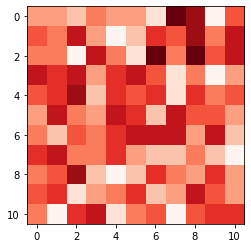

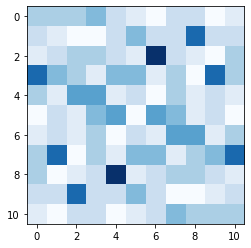

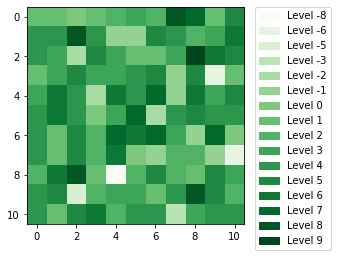

In [5]:
import matplotlib.pyplot as plt
import numpy as np
finalboard = [[4, 4, 3, 5, 4, 4, 2, 10, 9, 1, 6],
 [6, 5, 8, 4, 1, 3, 7, 6, 9, 5, 8],
 [5, 5, 1, 8, 5, 2, 10, 5, 10, 6, 8],
 [8, 7, 8, 4, 7, 8, 6, 2, 5, 1, 4],
 [6, 7, 9, 3, 7, 6, 7, 2, 7, 5, 6],
 [4, 8, 5, 4, 8, 7, 3, 8, 6, 6, 4],
 [5, 3, 6, 5, 7, 8, 8, 8, 4, 8, 3],
 [7, 8, 5, 5, 7, 4, 3, 3, 5, 3, 1],
 [5, 6, 9, 3, 1, 3, 7, 5, 4, 7, 4],
 [6, 7, 2, 4, 5, 7, 3, 4, 8, 6, 4],
 [5, 1, 7, 8, 2, 5, 6, 1, 6, 7, 7]]
a = np.asarray(finalboard)
plt.imshow(a, cmap='Reds')
plt.show()

# Difference map along axis (cause should be same ideally)

diff = []
for i in range(11):
    diff.append([])
    for j in range(11):
        diff[i].append(0)

for i in range(11):
    for j in range(11):
        diff[i][j] = abs( finalboard[i][j] - finalboard[10-i][10-j] )

b = np.asarray(diff)
plt.imshow(b, cmap='Blues')
plt.show() 

# Combination of difference and values 

import matplotlib.patches as mpatches

diffnvalue = []
for i in range(11):
    diffnvalue.append([])
    for j in range(11):
        diffnvalue[i].append(0)

for i in range(11):
    for j in range(11):
        diffnvalue[i][j] = finalboard[i][j] - diff[i][j] 

c = np.asarray(diffnvalue)
im = plt.imshow(c, cmap='Greens')

values = np.unique(c.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


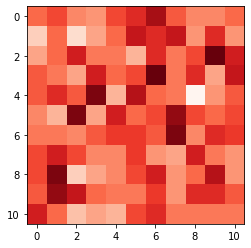

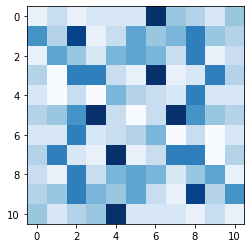

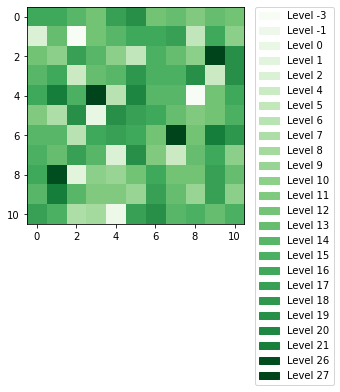

In [6]:
import matplotlib.pyplot as plt
import numpy as np

finalboard2 = [[17, 19, 15, 14, 19, 21, 25, 18, 15, 15, 17],
 [10, 17, 9, 13, 17, 23, 21, 23, 14, 21, 14],
 [13, 17, 22, 16, 16, 12, 21, 16, 19, 28, 22],
 [18, 16, 13, 22, 17, 19, 28, 16, 21, 13, 23],
 [18, 21, 18, 27, 12, 24, 17, 16, 6, 14, 18],
 [15, 12, 27, 13, 22, 17, 19, 26, 19, 17, 19],
 [16, 16, 15, 18, 20, 20, 18, 27, 15, 21, 20],
 [19, 22, 19, 15, 15, 20, 14, 13, 22, 16, 14],
 [19, 27, 10, 13, 15, 19, 22, 14, 17, 24, 14],
 [18, 26, 23, 17, 16, 16, 20, 14, 21, 21, 18],
 [22, 17, 11, 13, 12, 19, 21, 16, 16, 16, 16]]
# d = np.asarray([[8, 10, 8, 9, 4, 6, 9, 9, 10, 7, 10], [13, 10, 8, 8, 9, 11, 11, 14, 8, 7, 14], [7, 10, 10, 16, 11, 10, 13, 5, 9, 14, 6], [11, 8, 14, 9, 7, 12, 12, 14, 5, 10, 13], [11, 7, 9, 9, 11, 9, 7, 11, 19, 10, 9], [11, 7, 11, 12, 10, 9, 10, 6, 7, 9, 12], [10, 14, 11, 9, 8, 12, 10, 8, 10, 7, 6], [7, 9, 10, 5, 13, 6, 12, 13, 11, 14, 9], [11, 8, 10, 11, 8, 5, 6, 8, 9, 9, 8], [10, 9, 10, 7, 9, 4, 12, 8, 10, 9, 5], [12, 12, 3, 13, 7, 8, 5, 6, 8, 10, 11]])
d = np.asarray(finalboard2)
plt.imshow(d, cmap='Reds')
plt.show()

diff2 = []
for i in range(11):
    diff2.append([])
    for j in range(11):
        diff2[i].append(0)

for i in range(11):
    for j in range(11):
        diff2[i][j] = abs( finalboard2[i][j] - finalboard2[10-i][10-j] )

e = np.asarray(diff2)
plt.imshow(e, cmap='Blues')
plt.show() 


import matplotlib.patches as mpatches

diffnvalue2 = []
for i in range(11):
    diffnvalue2.append([])
    for j in range(11):
        diffnvalue2[i].append(0)

for i in range(11):
    for j in range(11):
        diffnvalue2[i][j] = finalboard2[i][j] - diff2[i][j] 

f = np.asarray(diffnvalue2)
im2 = plt.imshow(f, cmap='Greens')

values = np.unique(f.ravel())
colors = [ im2.cmap(im2.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

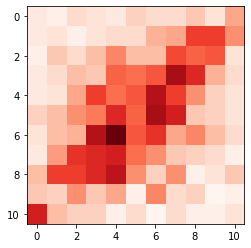

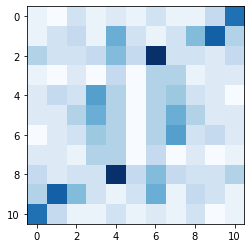

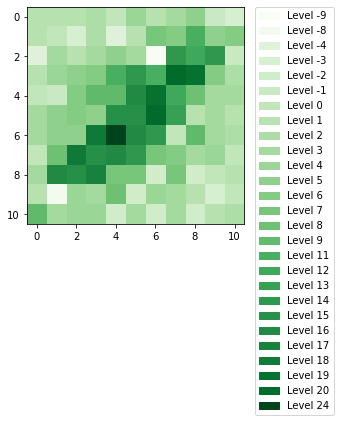

In [10]:
import matplotlib.pyplot as plt
import numpy as np

finalboard3 = [[2, 1, 4, 3, 2, 5, 4, 4, 6, 3, 9],
 [2, 3, 1, 3, 4, 4, 8, 9, 18, 18, 11],
 [1, 6, 4, 7, 12, 7, 7, 17, 15, 16, 3],
 [2, 4, 7, 6, 15, 14, 16, 25, 20, 8, 4],
 [2, 3, 9, 18, 14, 16, 24, 18, 11, 5, 3],
 [5, 7, 11, 13, 20, 15, 25, 21, 6, 5, 3],
 [3, 7, 8, 24, 29, 16, 19, 9, 12, 7, 4],
 [2, 10, 19, 20, 21, 14, 11, 6, 5, 4, 1],
 [7, 18, 18, 20, 23, 11, 5, 11, 1, 3, 6],
 [6, 5, 11, 6, 9, 1, 12, 4, 5, 0, 1],
 [21, 7, 5, 5, 1, 4, 0, 4, 1, 1, 3]]
# d = np.asarray([[8, 10, 8, 9, 4, 6, 9, 9, 10, 7, 10], [13, 10, 8, 8, 9, 11, 11, 14, 8, 7, 14], [7, 10, 10, 16, 11, 10, 13, 5, 9, 14, 6], [11, 8, 14, 9, 7, 12, 12, 14, 5, 10, 13], [11, 7, 9, 9, 11, 9, 7, 11, 19, 10, 9], [11, 7, 11, 12, 10, 9, 10, 6, 7, 9, 12], [10, 14, 11, 9, 8, 12, 10, 8, 10, 7, 6], [7, 9, 10, 5, 13, 6, 12, 13, 11, 14, 9], [11, 8, 10, 11, 8, 5, 6, 8, 9, 9, 8], [10, 9, 10, 7, 9, 4, 12, 8, 10, 9, 5], [12, 12, 3, 13, 7, 8, 5, 6, 8, 10, 11]])
d = np.asarray(finalboard3)
plt.imshow(d, cmap='Reds')
plt.show()

diff3 = []
for i in range(11):
    diff3.append([])
    for j in range(11):
        diff3[i].append(0)

for i in range(11):
    for j in range(11):
        diff3[i][j] = abs( finalboard3[i][j] - finalboard3[10-i][10-j] )

e = np.asarray(diff3)
plt.imshow(e, cmap='Blues')
plt.show() 


import matplotlib.patches as mpatches

diffnvalue3 = []
for i in range(11):
    diffnvalue3.append([])
    for j in range(11):
        diffnvalue3[i].append(0)

for i in range(11):
    for j in range(11):
        diffnvalue3[i][j] = finalboard3[i][j] - diff3[i][j] 

f = np.asarray(diffnvalue3)
im3 = plt.imshow(f, cmap='Greens')

values = np.unique(f.ravel())
colors = [ im3.cmap(im3.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

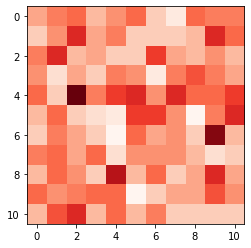

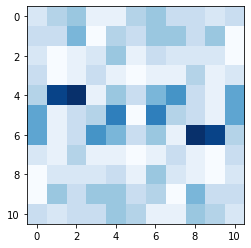

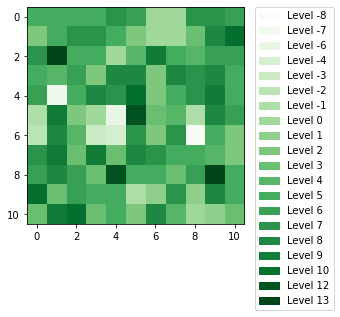

In [9]:
import matplotlib.pyplot as plt
import numpy as np

finalboard4 = [[7, 9, 10, 6, 8, 10, 5, 3, 10, 9, 9], [5, 8, 13, 7, 9, 5, 5, 5, 6, 13, 10], [9, 13, 6, 7, 5, 5, 12, 7, 6, 8, 6], [8, 4, 7, 5, 9, 8, 3, 9, 11, 9, 7], [10, 5, 18, 9, 12, 13, 8, 13, 10, 10, 12], [6, 10, 5, 4, 3, 12, 12, 8, 2, 9, 13], [5, 9, 7, 5, 2, 10, 7, 8, 5, 17, 6], [9, 10, 7, 10, 4, 8, 8, 8, 6, 4, 5], [6, 10, 8, 5, 15, 6, 10, 5, 7, 13, 7], [10, 8, 9, 10, 10, 2, 5, 7, 7, 11, 8], [6, 11, 13, 6, 10, 6, 9, 5, 5, 5, 5]]

# d = np.asarray([[8, 10, 8, 9, 4, 6, 9, 9, 10, 7, 10], [13, 10, 8, 8, 9, 11, 11, 14, 8, 7, 14], [7, 10, 10, 16, 11, 10, 13, 5, 9, 14, 6], [11, 8, 14, 9, 7, 12, 12, 14, 5, 10, 13], [11, 7, 9, 9, 11, 9, 7, 11, 19, 10, 9], [11, 7, 11, 12, 10, 9, 10, 6, 7, 9, 12], [10, 14, 11, 9, 8, 12, 10, 8, 10, 7, 6], [7, 9, 10, 5, 13, 6, 12, 13, 11, 14, 9], [11, 8, 10, 11, 8, 5, 6, 8, 9, 9, 8], [10, 9, 10, 7, 9, 4, 12, 8, 10, 9, 5], [12, 12, 3, 13, 7, 8, 5, 6, 8, 10, 11]])
d = np.asarray(finalboard4)
plt.imshow(d, cmap='Reds')
plt.show()

diff4 = []
for i in range(11):
    diff4.append([])
    for j in range(11):
        diff4[i].append(0)

for i in range(11):
    for j in range(11):
        diff4[i][j] = abs( finalboard4[i][j] - finalboard4[10-i][10-j] )

e = np.asarray(diff4)
plt.imshow(e, cmap='Blues')
plt.show() 


import matplotlib.patches as mpatches

diffnvalue4 = []
for i in range(11):
    diffnvalue4.append([])
    for j in range(11):
        diffnvalue4[i].append(0)

for i in range(11):
    for j in range(11):
        diffnvalue4[i][j] = finalboard4[i][j] - diff4[i][j] 

f = np.asarray(diffnvalue4)
im4 = plt.imshow(f, cmap='Greens')

values = np.unique(f.ravel())
colors = [ im4.cmap(im4.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

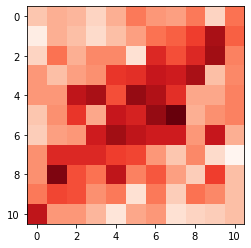

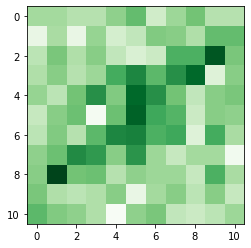

In [14]:
finalcombined1 = []
finalcombined2 = []
for i in range(11):
    finalcombined1.append([])
    finalcombined2.append([])
    for j in range(11):
        finalcombined1[i].append(0)
        finalcombined2[i].append(0)

for i in range(11):
    for j in range(11):
        finalcombined1[i][j] = finalboard[i][j] + finalboard2[i][j] + finalboard3[i][j] + finalboard4[i][j]
        finalcombined2[i][j] = diffnvalue[i][j] + diffnvalue2[i][j] + diffnvalue3[i][j] + diffnvalue4[i][j]
d = np.asarray(finalcombined1)
plt.imshow(d, cmap='Reds')
plt.show()
d = np.asarray(finalcombined2)
plt.imshow(d, cmap='Greens')
plt.show()

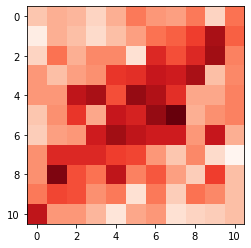

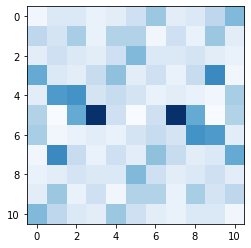

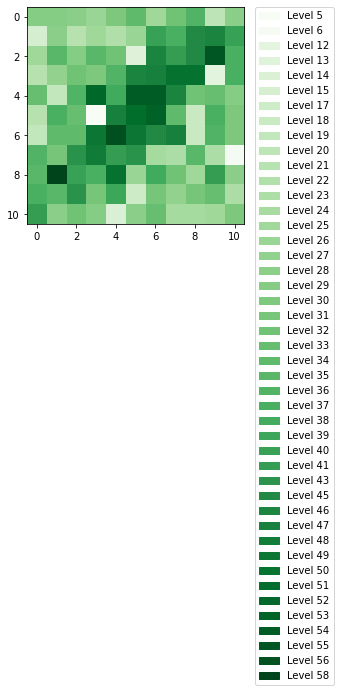

In [15]:
finalboard5 = []
for i in range(11):
    finalboard5.append([])
    for j in range(11):
        finalboard5[i].append(0)

for i in range(11):
    for j in range(11):
        finalboard5[i][j] = finalboard[i][j] + finalboard2[i][j] + finalboard3[i][j] + finalboard4[i][j]
        

# d = np.asarray([[8, 10, 8, 9, 4, 6, 9, 9, 10, 7, 10], [13, 10, 8, 8, 9, 11, 11, 14, 8, 7, 14], [7, 10, 10, 16, 11, 10, 13, 5, 9, 14, 6], [11, 8, 14, 9, 7, 12, 12, 14, 5, 10, 13], [11, 7, 9, 9, 11, 9, 7, 11, 19, 10, 9], [11, 7, 11, 12, 10, 9, 10, 6, 7, 9, 12], [10, 14, 11, 9, 8, 12, 10, 8, 10, 7, 6], [7, 9, 10, 5, 13, 6, 12, 13, 11, 14, 9], [11, 8, 10, 11, 8, 5, 6, 8, 9, 9, 8], [10, 9, 10, 7, 9, 4, 12, 8, 10, 9, 5], [12, 12, 3, 13, 7, 8, 5, 6, 8, 10, 11]])
d = np.asarray(finalboard5)
plt.imshow(d, cmap='Reds')
plt.show()

diff5 = []
for i in range(11):
    diff5.append([])
    for j in range(11):
        diff5[i].append(0)

for i in range(11):
    for j in range(11):
        diff5[i][j] = abs( finalboard5[i][j] - finalboard5[10-i][10-j] )

e = np.asarray(diff5)
plt.imshow(e, cmap='Blues')
plt.show() 


import matplotlib.patches as mpatches

diffnvalue5 = []
for i in range(11):
    diffnvalue5.append([])
    for j in range(11):
        diffnvalue5[i].append(0)

for i in range(11):
    for j in range(11):
        diffnvalue5[i][j] = finalboard5[i][j] - diff5[i][j] 

f = np.asarray(diffnvalue5)
im5 = plt.imshow(f, cmap='Greens')

values = np.unique(f.ravel())
colors = [ im5.cmap(im5.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )